In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here
import pydicom
import glob
from itertools import chain

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [4]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
65928,00016291_012.png,Infiltration|Pneumonia,12,16291,54,M,AP,2500,2048,0.168,0.168,NaN
35729,00009418_002.png,No Finding,2,9418,65,M,AP,2500,2048,0.168,0.168,NaN
83207,00020435_000.png,No Finding,0,20435,29,F,PA,2992,2991,0.143,0.143,NaN


In [6]:
## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
4866,00025580_011.png,Atelectasis,11,25580,046Y,M,PA,2530,2991,0.143,0.143
936,00004893_022.png,Atelectasis,22,4893,029Y,M,AP,2500,2048,0.171,0.171
750,00003923_018.png,Infiltration,18,3923,028Y,M,AP,2500,2048,0.171,0.171


# Explore 2D Imaging Properties

## No Finding

### Step 1: 
test1.dcm has a diagnosis of No Finding.  Read the DICOM's pixel_array attribute into a dataframe using the pydicom.dcmread function

In [8]:
dcm = pydicom.dcmread("test1.dcm")
pixels0 = dcm.pixel_array

### Step 2: 
Visualize the image using plt.imshow

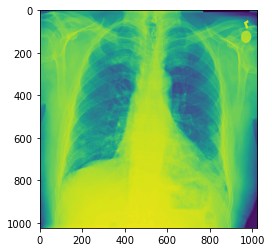

In [23]:
plt.imshow(pixels0)

### Step 3: 
plot a histogram of the image pixel intensity values

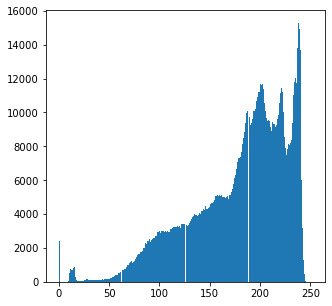

In [12]:
plt.figure(figsize=(5,5))
plt.hist(pixels0.ravel(), bins = 256)
plt.show()

Note the peak at zero, which are background pixels. This distribution makes it seem like the mean intensity is probably around 200, but let's find out for sure:

### Step 4: 
Find the mean and std dev intensity values of the image, and standerdize it

In [12]:
mean_intensity = np.mean(dcm.pixel_array)
mean_intensity

180.0586576461792

In [11]:
std_intensity = np.std(dcm.pixel_array)
std_intensity

47.89115072730743

In [13]:
new_img = dcm.pixel_array.copy()
new_img = (new_img - mean_intensity)/std_intensity

### Step 5: 
Re-plot a histogram of the normalized intensity values

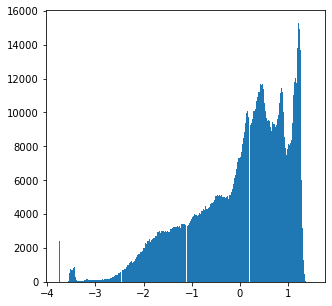

In [15]:
plt.figure(figsize=(5,5))
_ = plt.hist(new_img.ravel(), bins = 256)

Notice how the histogram has the same shape, but now it's centered around 0. This is a key step in image pre-processing when we prepare imaging data for machine learning.

Now let's look at images for particular conditions.

## Pneumonia

In [6]:
all_xray_df[all_xray_df['Finding Labels'] == 'Pneumonia'].iloc[0]['Image Index']

'00000061_015.png'

# Prepare DICOM Images for ML

In [3]:
## First, read all of my DICOM files into a list
mydicoms = glob.glob("*.dcm")

### Let's look at the contents of the first DICOM:

In [4]:
dcm1 = pydicom.dcmread(mydicoms[0])

In [5]:
dcm1

(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.11129.5.5.110503645592756492463169821050252582267888
(0008, 0060) Modality                            CS: 'CT'
(0008, 1030) Study Description                   LO: 'No Finding'
(0010, 0020) Patient ID                          LO: '2'
(0010, 0040) Patient's Sex                       CS: 'M'
(0010, 1010) Patient's Age                       AS: '81'
(0018, 0015) Body Part Examined                  CS: 'CHEST'
(0018, 5100) Patient Position                    CS: 'PA'
(0020, 000d) Study Instance UID                  UI: 1.3.6.1.4.1.11129.5.5.112507010803284478207522016832191866964708
(0020, 000e) Series Instance UID                 UI: 1.3.6.1.4.1.11129.5.5.112630850362182468372440828755218293352329
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows       

Looking at the attributes listed above, I can see that I'm looking to extract the following attributes: 
* Modality
* Study Description
* Patient ID
* Patient's Sex
* Patient's Age
* Rows
* Columns

In [6]:
dcm1.Modality

'CT'

In [7]:
dcm1.StudyDescription

'No Finding'

In [8]:
dcm1.PatientID

'2'

In [9]:
dcm1.PatientSex

'M'

In [10]:
dcm1.PatientAge

'81'

In [11]:
dcm1.Rows

1024

In [12]:
dcm1.Columns

1024

## Now, let's create the dataframe that we want, and populate it in a loop with all of our DICOMS:

In [13]:
all_data = []

for i in mydicoms: 
    dcm = pydicom.dcmread(i)
    fields = [dcm.PatientID, int(dcm.PatientAge), dcm.PatientSex, dcm.Modality, dcm.StudyDescription,
             dcm.Rows, dcm.Columns]
    all_data.append(fields)

In [14]:
mydata = pd.DataFrame(all_data, 
                      columns = ['PatientID','PatientAge','PatientSex','Modality','Findings','Rows','Columns'])

In [15]:
mydata

,PatientID,PatientAge,PatientSex,Modality,Findings,Rows,Columns
0,2,81,M,CT,No Finding,1024,1024
1,2,81,M,DX,No Finding,1024,1024
2,2,81,M,DX,No Finding,1024,1024
3,1,58,M,DX,Cardiomegaly,1024,1024
4,61,77,M,DX,Effusion,1024,1024
5,2,81,M,DX,No Finding,1024,1024


# Exploring Population Metadata

In [16]:
d = pd.read_csv('sample_labels.csv')

In [19]:
## Here I'm just going to split up my "Finding Labels" column so that I have one column in my dataframe
# per disease, with a binary flag. This makes EDA a lot easier! 

all_labels = np.unique(list(chain(*d['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        d[c_label] = d['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
d.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
2672,00013505_002.png,Consolidation|Effusion|Infiltration,2,13505,076Y,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2387,00012045_049.png,Effusion|Nodule,49,12045,048Y,F,PA,2422,2361,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1916,00010007_133.png,Effusion|Pleural_Thickening,133,10007,058Y,M,AP,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [20]:
len(all_labels)

15

I see here that there are 15 unique types of labels found in my dataset

In [21]:
d[all_labels].sum()/len(d)

Atelectasis           0.090617
Cardiomegaly          0.025152
Consolidation         0.040314
Edema                 0.021049
Effusion              0.114877
Emphysema             0.022654
Fibrosis              0.014984
Hernia                0.002319
Infiltration          0.172494
Mass                  0.050660
No Finding            0.542990
Nodule                0.055833
Pleural_Thickening    0.031395
Pneumonia             0.011060
Pneumothorax          0.048341
dtype: float64

[Text(0, 0.5, 'Number of Images with Label')]

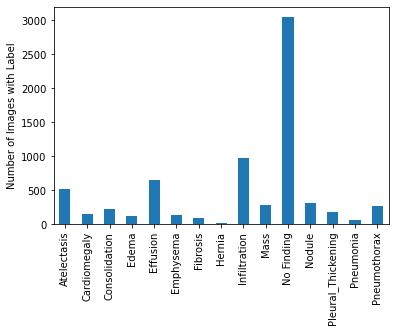

In [22]:
ax = d[all_labels].sum().plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')

Above, I see the relative frequencies of each disease in my dataset. It looks like 'No Finding' is the most common occurrence. 'No Finding' can never appear with any other label by definition, so we know that in 54.3% of this dataset, there is no finding in the image. Beyond that, it appears that 'Infiltration' is the most common disease-related label, and it is followed by 'Effusion' and 'Atelectasis.'

Since 'pneumonia' is what we're concerned with, I'm going to now look at how frequently it appears with all of the other diseases: 

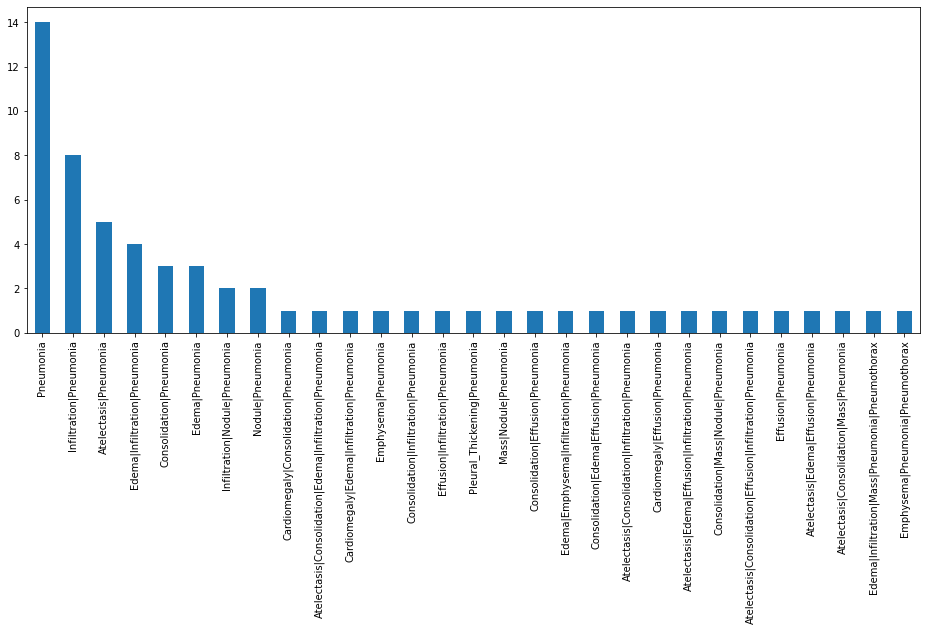

In [24]:
##Since there are many combinations of potential findings, I'm going to look at the 30 most common co-occurrences:
plt.figure(figsize=(16,6))
d[d.Pneumonia==1]['Finding Labels'].value_counts()[0:30].plot(kind='bar')

It looks like pneumonia actually occurs alone for the most part, and that its most-common comorbidities are infiltration and atelectasis.

Now let's move on to looking at age & gender: 

In [29]:
pd.unique(d['Patient Age'])

array(['060Y', '057Y', '077Y', '079Y', '055Y', '068Y', '071Y', '063Y',
       '067Y', '056Y', '058Y', '075Y', '073Y', '054Y', '078Y', '047Y',
       '050Y', '045Y', '084Y', '030Y', '049Y', '061Y', '069Y', '051Y',
       '044Y', '087Y', '059Y', '031Y', '064Y', '053Y', '082Y', '072Y',
       '046Y', '080Y', '048Y', '021Y', '038Y', '062Y', '052Y', '023Y',
       '037Y', '022Y', '032Y', '070Y', '065Y', '040Y', '042Y', '041Y',
       '028Y', '035Y', '034Y', '066Y', '019Y', '039Y', '074Y', '026Y',
       '024Y', '085Y', '016Y', '029Y', '033Y', '013Y', '017Y', '020Y',
       '014Y', '043Y', '012Y', '009Y', '011Y', '027Y', '036Y', '081Y',
       '025Y', '018Y', '076Y', '083Y', '008Y', '006Y', '015Y', '002Y',
       '005Y', '010Y', '003Y', '089Y', '007Y', '086Y', '004Y', '094Y',
       '013M', '411Y', '001D', '088Y'], dtype=object)

In [30]:
def get_age_from_string(age_str):
    if age_str[-1] == 'D':
        return 0
    elif age_str[-1] == 'M':
        return 1
    else:
        stripped_age = age_str[:3].strip("0")
        if len(stripped_age) == 0:
            return 0
        else:
            return int(stripped_age)

In [32]:
d['AgeInYears'] = d['Patient Age'].map(lambda age_str: get_age_from_string(age_str))

Clearly no one can be 411 years old.

In [34]:
d = d[d['AgeInYears'] < 411]

(array([ 631.,  230.,  542.,  625.,  779., 1202.,  977.,  493.,  112.,
          14.]),
 array([ 0. ,  9.4, 18.8, 28.2, 37.6, 47. , 56.4, 65.8, 75.2, 84.6, 94. ]),
 <a list of 10 Patch objects>)

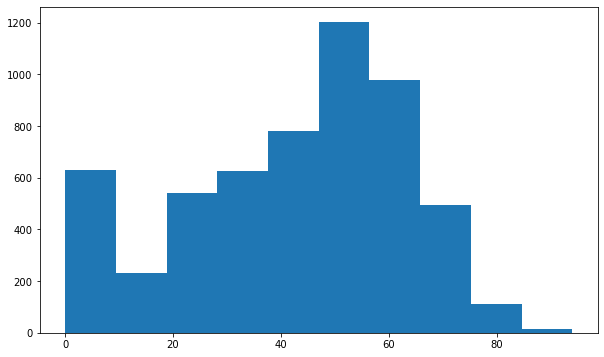

In [36]:
plt.figure(figsize=(10,6))
plt.hist(d['AgeInYears'])

(array([ 8.,  5.,  5.,  6.,  3.,  9.,  4., 12.,  5.,  5.]),
 array([ 2. ,  9.4, 16.8, 24.2, 31.6, 39. , 46.4, 53.8, 61.2, 68.6, 76. ]),
 <a list of 10 Patch objects>)

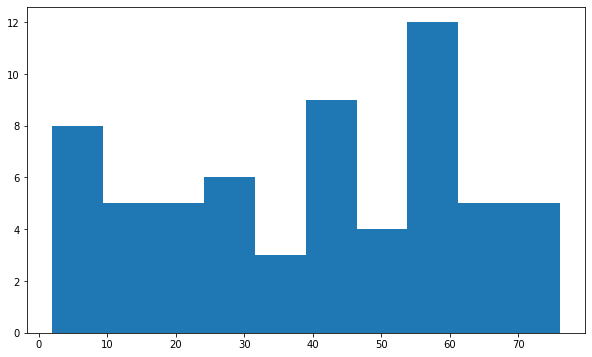

In [37]:
plt.figure(figsize=(10,6))
plt.hist(d[d.Pneumonia==1]['AgeInYears'])

Looks like the distribution of age across the whole population is quite different than it is specifically for pneumonia. Pneumonia occurs across all ages, although there is a peak at 60.

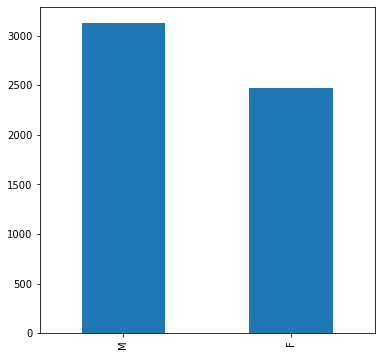

In [38]:
plt.figure(figsize=(6,6))
d['Patient Gender'].value_counts().plot(kind='bar')

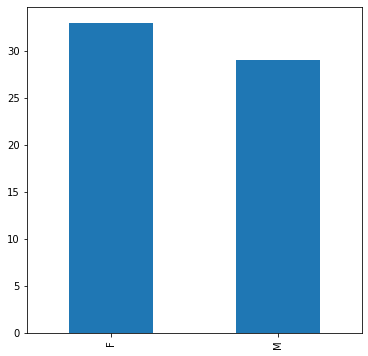

In [39]:
plt.figure(figsize=(6,6))
d[d.Pneumonia ==1]['Patient Gender'].value_counts().plot(kind='bar')

There are more males than females in the general population, but more females have pneumonia.